主要任务:  
1、文献综述:请对经典和近期波动率预测相关文献进行综述(涉及至少十篇文章);  
2、实证预测:请自选时间序列分析方法，对2017.01-2022.12的波动率进行(伪)样本外预测，并评价模型的预测效果。  
那个模型garch、tgarch、egarch都行

选用一种课上所讲授预测方法，一种课外预测方法(可参考论文或教材选取)。
2.详细阐述所选课外方法的理论模型、使用步骤、方法特征、选取理由。
3.选取不少于三种评估标准对两种方法的预测结果进行
评估和比较。

In [39]:
#导入股票数据

import efinance as ef
stock_code = '399905'
df = ef.stock.get_quote_history(stock_code)

In [40]:
#导入股票数据

import efinance as ef
stock_code = '000300'
df2 = ef.stock.get_quote_history(stock_code)

In [41]:
# 将日期列转换为日期时间类型
df['日期'] = pd.to_datetime(df['日期'])
# 设置日期列为索引
df.set_index('日期', inplace=True)
# 选择指定日期范围的数据
start_date = '2017-01-01'
end_date = '2022-12-31'
filtered_data = df.loc[start_date:end_date]
df = filtered_data
# 将日期列转换为日期时间类型
df2['日期'] = pd.to_datetime(df2['日期'])
# 设置日期列为索引
df2.set_index('日期', inplace=True)
# 选择指定日期范围的数据
start_date = '2017-01-01'
end_date = '2022-12-31'
filtered_data2 = df2.loc[start_date:end_date]
df2 = filtered_data2

In [15]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential

In [71]:
#声明归一化变量
sc_data = df['收盘'].values
sc = MinMaxScaler(feature_range=(0, 1))
#反归一化
sc_data = sc.fit_transform(sc_data.reshape(-1,1))

In [43]:
seq_len = 2  #时间步长 t-5,t-4,t-3,t-2,t-1 --->t
#转换成LSTM所需格式，（样本数，步长，特征数）
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])
print(X_train.shape,y_train.shape)

(1457, 2, 1) (1457, 1)


In [28]:
#lstm网络,keras
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))#lstm层，神经元数为128
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm层，神经元数为128
model.add(Dropout(0.2))#dropout层
model.add(Dense(1))#全连接层
model.compile(loss='mean_squared_error', optimizer='adam')
#训练
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
46/46 - 2s - loss: 0.1041 - 2s/epoch - 38ms/step
Epoch 2/100
46/46 - 0s - loss: 0.0102 - 87ms/epoch - 2ms/step
Epoch 3/100
46/46 - 0s - loss: 0.0074 - 84ms/epoch - 2ms/step
Epoch 4/100
46/46 - 0s - loss: 0.0052 - 80ms/epoch - 2ms/step
Epoch 5/100
46/46 - 0s - loss: 0.0038 - 76ms/epoch - 2ms/step
Epoch 6/100
46/46 - 0s - loss: 0.0030 - 78ms/epoch - 2ms/step
Epoch 7/100
46/46 - 0s - loss: 0.0026 - 80ms/epoch - 2ms/step
Epoch 8/100
46/46 - 0s - loss: 0.0026 - 79ms/epoch - 2ms/step
Epoch 9/100
46/46 - 0s - loss: 0.0025 - 78ms/epoch - 2ms/step
Epoch 10/100
46/46 - 0s - loss: 0.0026 - 80ms/epoch - 2ms/step
Epoch 11/100
46/46 - 0s - loss: 0.0026 - 79ms/epoch - 2ms/step
Epoch 12/100
46/46 - 0s - loss: 0.0025 - 78ms/epoch - 2ms/step
Epoch 13/100
46/46 - 0s - loss: 0.0024 - 77ms/epoch - 2ms/step
Epoch 14/100
46/46 - 0s - loss: 0.0022 - 76ms/epoch - 2ms/step
Epoch 15/100
46/46 - 0s - loss: 0.0022 - 79ms/epoch - 2ms/step
Epoch 16/100
46/46 - 0s - loss: 0.0023 - 80ms/epoch - 2ms/step
Ep

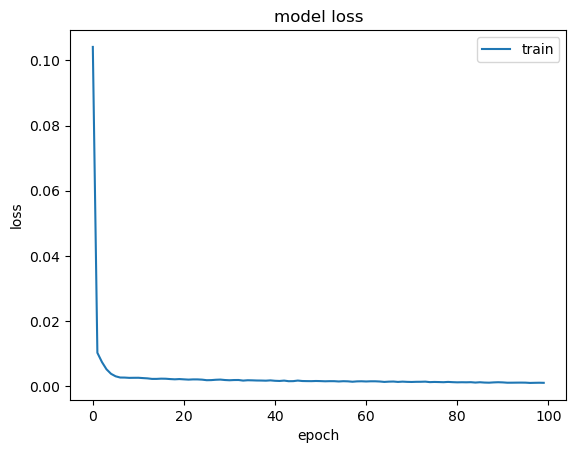

In [29]:
# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [72]:
# 预测训练集数据，预测数据为残缺项数据
lstm_pred = model.predict(X_train)
#对lstm_pred进行反归一化
lstm_pred = sc.inverse_transform(lstm_pred)#反归一化数据为为残缺项数据的预测数据
#对y_train进行反归一化
ytrue = sc.inverse_transform(y_train.reshape(-1,1))#反归一化数据为残缺项数据的真实值

46/46 [==============================] - 0s 1ms/step


In [74]:
#计算评价指标
mse = mean_squared_error(ytrue, lstm_pred)
mae = mean_absolute_error(ytrue, lstm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,lstm_pred)

print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 7490.554
mae: 63.237
rmse: 86.548
r2: 0.987


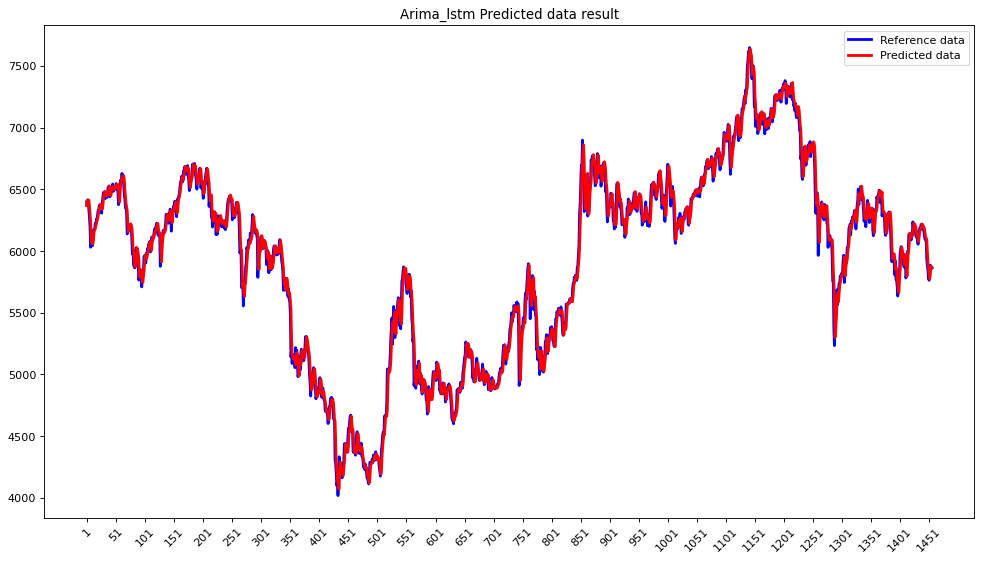

In [75]:
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ytrue, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(lstm_pred, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(lstm_pred),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

In [76]:
# 初始的输入数据
current_input = np.array([sc_data[-seq_len:, :]])

# 预测未来5天的数据
future_predictions = []

for _ in range(5):
    # 调整输入数据的形状以符合模型的输入要求
    current_input = current_input.reshape((current_input.shape[0], current_input.shape[1], current_input.shape[2]))

    # 使用模型进行当前时间点的预测
    current_prediction = model.predict(current_input)

    # 将当前预测值添加到输入序列中，准备下一次预测
    current_input = np.concatenate((current_input[:, 1:, :], np.expand_dims(current_prediction, axis=1)), axis=1)

    # 将当前预测值记录下来
    future_predictions.append(current_prediction[0, 0])  # 取第一个预测值，你可能需要根据实际情况选择合适的值

# 将预测结果转换为数组
future_predictions = np.array(future_predictions)

print("预测的未来5天数据:", future_predictions)

1/1 [==============================] - 0s 14ms/step
预测的未来5天数据: [0.508557   0.5095353  0.51007223 0.51082915 0.51148564]


In [82]:
# 创建一个新的DataFrame，只包含调整后的收盘价
data = pd.DataFrame({'Adj Close': future_predictions})

In [91]:
y2 = ytrue/10000
y3 = np.append(y2, future_predictions)
y3

array([0.639928  , 0.637162  , 0.641542  , ..., 0.51007223, 0.51082915,
       0.51148564])

In [93]:
# 指定过去数据的窗口大小（假设为5天）
window_size = 5

# 计算每日收盘价的百分比变化
daily_returns = np.diff(y3) / y3[:-1]

# 计算每日波动率序列
daily_volatility = np.zeros_like(daily_returns)

for i in range(window_size - 1, len(daily_returns)):
    window_data = daily_returns[i - window_size + 1: i + 1]
    daily_volatility[i] = np.std(window_data)

print("每日波动率序列:", daily_volatility)

每日波动率序列: [0.         0.         0.         ... 0.05347254 0.05369435 0.05370211]


In [94]:
daily_volatility[-5:]

array([0.05361846, 0.05299916, 0.05347254, 0.05369435, 0.05370211])

In [95]:
#声明归一化变量
sc_data = df2['收盘'].values
sc = MinMaxScaler(feature_range=(0, 1))
#反归一化
sc_data = sc.fit_transform(sc_data.reshape(-1,1))

In [96]:
seq_len = 2  #时间步长 t-5,t-4,t-3,t-2,t-1 --->t
#转换成LSTM所需格式，（样本数，步长，特征数）
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])
print(X_train.shape,y_train.shape)

(1457, 2, 1) (1457, 1)


In [97]:
#lstm网络,keras
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))#lstm层，神经元数为128
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm层，神经元数为128
model.add(Dropout(0.2))#dropout层
model.add(Dense(1))#全连接层
model.compile(loss='mean_squared_error', optimizer='adam')
#训练
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
46/46 - 2s - loss: 0.0825 - 2s/epoch - 38ms/step
Epoch 2/100
46/46 - 0s - loss: 0.0121 - 87ms/epoch - 2ms/step
Epoch 3/100
46/46 - 0s - loss: 0.0067 - 86ms/epoch - 2ms/step
Epoch 4/100
46/46 - 0s - loss: 0.0033 - 82ms/epoch - 2ms/step
Epoch 5/100
46/46 - 0s - loss: 0.0020 - 84ms/epoch - 2ms/step
Epoch 6/100
46/46 - 0s - loss: 0.0020 - 82ms/epoch - 2ms/step
Epoch 7/100
46/46 - 0s - loss: 0.0019 - 86ms/epoch - 2ms/step
Epoch 8/100
46/46 - 0s - loss: 0.0019 - 84ms/epoch - 2ms/step
Epoch 9/100
46/46 - 0s - loss: 0.0019 - 85ms/epoch - 2ms/step
Epoch 10/100
46/46 - 0s - loss: 0.0017 - 87ms/epoch - 2ms/step
Epoch 11/100
46/46 - 0s - loss: 0.0018 - 86ms/epoch - 2ms/step
Epoch 12/100
46/46 - 0s - loss: 0.0018 - 83ms/epoch - 2ms/step
Epoch 13/100
46/46 - 0s - loss: 0.0017 - 83ms/epoch - 2ms/step
Epoch 14/100
46/46 - 0s - loss: 0.0017 - 87ms/epoch - 2ms/step
Epoch 15/100
46/46 - 0s - loss: 0.0015 - 85ms/epoch - 2ms/step
Epoch 16/100
46/46 - 0s - loss: 0.0016 - 86ms/epoch - 2ms/step
Ep

In [98]:
# 预测训练集数据，预测数据为残缺项数据
lstm_pred = model.predict(X_train)
#对lstm_pred进行反归一化
lstm_pred = sc.inverse_transform(lstm_pred)#反归一化数据为为残缺项数据的预测数据
#对y_train进行反归一化
ytrue = sc.inverse_transform(y_train.reshape(-1,1))#反归一化数据为残缺项数据的真实值

46/46 [==============================] - 0s 1ms/step


In [99]:
#计算评价指标
mse = mean_squared_error(ytrue, lstm_pred)
mae = mean_absolute_error(ytrue, lstm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,lstm_pred)

print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 3588.179
mae: 45.133
rmse: 59.901
r2: 0.990


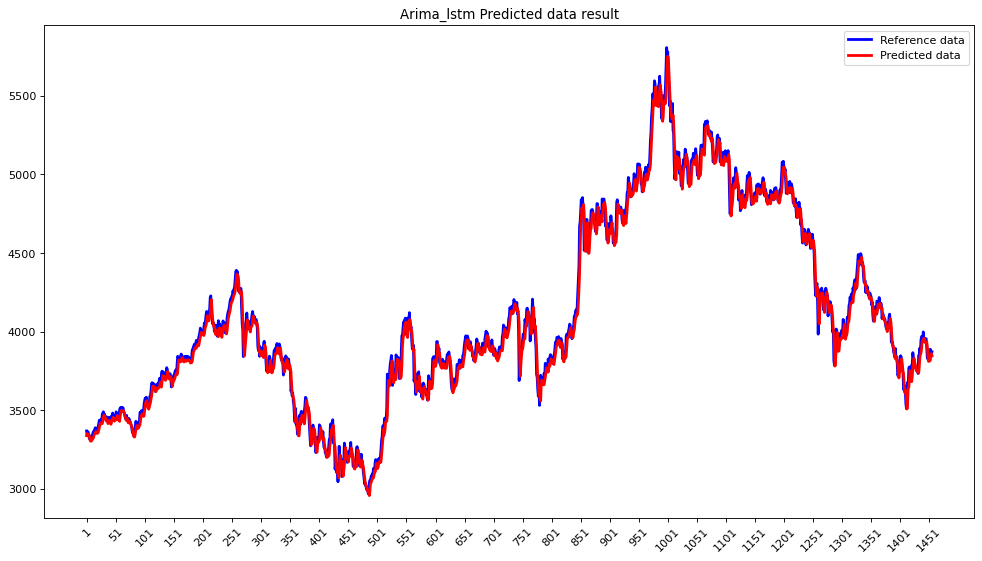

In [100]:
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ytrue, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(lstm_pred, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(lstm_pred),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.show()

In [101]:
# 初始的输入数据
current_input = np.array([sc_data[-seq_len:, :]])

# 预测未来5天的数据
future_predictions = []

for _ in range(5):
    # 调整输入数据的形状以符合模型的输入要求
    current_input = current_input.reshape((current_input.shape[0], current_input.shape[1], current_input.shape[2]))

    # 使用模型进行当前时间点的预测
    current_prediction = model.predict(current_input)

    # 将当前预测值添加到输入序列中，准备下一次预测
    current_input = np.concatenate((current_input[:, 1:, :], np.expand_dims(current_prediction, axis=1)), axis=1)

    # 将当前预测值记录下来
    future_predictions.append(current_prediction[0, 0])  # 取第一个预测值，你可能需要根据实际情况选择合适的值

# 将预测结果转换为数组
future_predictions = np.array(future_predictions)

print("预测的未来5天数据:", future_predictions)

1/1 [==============================] - 0s 15ms/step
预测的未来5天数据: [0.30944085 0.3074593  0.3016382  0.29778755 0.2929417 ]


In [102]:
# 创建一个新的DataFrame，只包含调整后的收盘价
data = pd.DataFrame({'Adj Close': future_predictions})
y2 = ytrue/10000
y3 = np.append(y2, future_predictions)
# 指定过去数据的窗口大小（假设为5天）
window_size = 5

# 计算每日收盘价的百分比变化
daily_returns = np.diff(y3) / y3[:-1]

# 计算每日波动率序列
daily_volatility = np.zeros_like(daily_returns)

for i in range(window_size - 1, len(daily_returns)):
    window_data = daily_returns[i - window_size + 1: i + 1]
    daily_volatility[i] = np.std(window_data)

print("每日波动率序列:", daily_volatility)

每日波动率序列: [0.         0.         0.         ... 0.07812224 0.07724518 0.07497917]


In [103]:
daily_volatility[-5:]

array([0.08124332, 0.07931935, 0.07812224, 0.07724518, 0.07497917])